# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from helpers import parse_variables, get_risk_level, map_to_color
import warnings
from scipy.stats import t
from scipy import stats
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input, Model, layers, regularizers
warnings.filterwarnings("ignore")


2024-06-26 17:16:05.359322: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 17:16:05.888791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 17:16:05.888915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 17:16:06.009065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-26 17:16:06.229251: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 17:16:06.233547: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def lin_reg(y, x, covariates=None):
    # Reshape x to have a single feature
    x = x.reshape(-1, 1)
    
    if covariates is not None:
        # Ensure covariates are 2D
        if len(covariates.shape) == 1:
            covariates = covariates.reshape(-1, 1)
        # Combine x and covariates
        X = np.hstack((x, covariates))
    else:
        X = x
    
    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Extract coefficients
    intercept = model.intercept_
    betas = model.coef_
    
    # Coefficient of x (first feature)
    beta_x = betas[0]
    
    # Calculate residuals
    y_hat = model.predict(X)
    residuals = y - y_hat
    
    # Degrees of freedom
    n = len(y)
    k = X.shape[1]  # Number of predictors including covariates
    df_resid = n - k - 1  # n - (k + 1) because of the intercept
    
    # Residual standard error
    s_e = np.sqrt(np.sum(residuals**2) / df_resid)
    
    # Calculate standard error of the coefficient of x
    X_with_intercept = np.hstack((np.ones((n, 1)), X))
    XTX_inv = np.linalg.inv(X_with_intercept.T @ X_with_intercept)
    se_beta_x = s_e * np.sqrt(XTX_inv[1, 1])
    
    # Calculate t-value for the coefficient of x
    t_value_x = beta_x / se_beta_x
    
    # Calculate p-value for the coefficient of x
    p_value_x = (1 - t.cdf(np.abs(t_value_x), df_resid)) * 2
    
    # Return results specifically for x
    return intercept, beta_x, se_beta_x, t_value_x, p_value_x

In [3]:
def simulate_quant_trait(mu, genotypes, beta=0, env=0):
    mean = mu + np.dot(genotypes,beta) + env

    true_mean = sum(mean) / len(mean)
    mean = mean - true_mean
    trait = []
    for element in mean:
        trait.append(np.random.normal(element,1))
    return trait

In [4]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks"
}

# Load genotype

In [5]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [6]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
name_risk

'NW_risk'

In [7]:
nr_common_PCs = 2
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
nr_rare_PCs = 5
rare_pc_columns = ['PC{}'.format(i) for i in range(1, nr_rare_PCs+1)]

In [8]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [9]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)

In [10]:
complete

snps,C0_AF_0.296425,C1_AF_0.21885,C2_AF_0.21275,C3_AF_0.2368,C4_AF_0.217525,C5_AF_0.20005,C6_AF_0.26035,C7_AF_0.3068,C8_AF_0.222275,C9_AF_0.296525,...,VR275_AF_0.0094,VR276_AF_0.00495,VR277_AF_0.0182,VR278_AF_0.008725,VR279_AF_0.003725,VR280_AF_0.016075,VR281_AF_0.0108,VR282_AF_0.008,VR283_AF_0.010525,VR284_AF_0.00345
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")

# Create phenotype

In [12]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])

In [13]:
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk])))

# No correction

In [14]:
Ps_no_corr = []
snps_no_corr = []
coefs_no_corr = []
intercepts_no_corr = []
faulty_snps_no_corr = []
AFs_no_corr = []
# create phenotype
for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X = np.array(list(complete[snp]))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        snps_no_corr.append(snp.split("_AF_")[0])
        Ps_no_corr.append(p_values) 
        AFs_no_corr.append(snp.split("_AF_")[1])
        coefs_no_corr.append(beta_hat)
    except Exception as e:
        faulty_snps_no_corr.append(snp)
        print(e)

In [15]:
Ps_no_corr = np.sort(Ps_no_corr)
epsilon = 1e-100

In [16]:
logPs_no_corr = np.sort(-np.log10(Ps_no_corr+epsilon))
no_corr_df = pd.DataFrame({'coeff':coefs_no_corr, "AFs":AFs_no_corr, "Ps_no_corr": Ps_no_corr})

In [17]:
n = len(no_corr_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))

In [18]:
no_corr_df['expected_P'] = expected_quantiles
no_corr_df['logPs_no_corr'] = logPs_no_corr
no_corr_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_no_corr'>

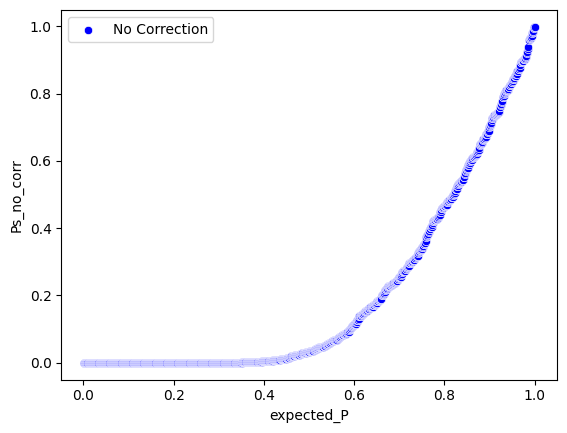

In [19]:
sns.scatterplot(x='expected_P', y='Ps_no_corr', data=no_corr_df, color='blue', label='No Correction')

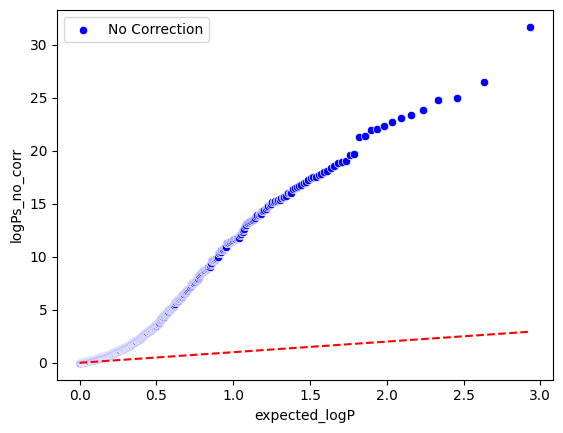

In [20]:
sns.scatterplot(x='expected_logP', y='logPs_no_corr', data=no_corr_df, color='blue', label='No Correction')
# Plot diagonal reference line
plt.plot([min(no_corr_df['expected_logP']), max(no_corr_df['expected_logP'])], 
         [min(no_corr_df['expected_logP']), max(no_corr_df['expected_logP'])], 
         color='red', linestyle='--')

# rare PCA correction

In [21]:
PC_veryrare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")

In [22]:
PC_veryrare

,PC1,PC2,PC3,PC4,PC5,populations,population_number,x,y,population
0,-1.417752,0.652165,-0.693068,-2.067152,-2.166243,pop 1,0.0025,1,1,1
1,-1.417752,0.652165,-0.693068,-2.067152,-2.166243,pop 1,0.0025,1,1,1
2,-1.417752,0.652165,-0.693068,-2.067152,-2.166243,pop 1,0.0025,1,1,1
3,-1.303522,0.603442,-0.619919,-1.886664,-1.997663,pop 1,0.0025,1,1,1
4,-1.417752,0.652165,-0.693068,-2.067152,-2.166243,pop 1,0.0025,1,1,1
...,...,...,...,...,...,...,...,...,...,...
19995,3.895860,1.624981,-0.306817,0.344594,-1.659752,pop 400,1.0000,20,20,400
19996,3.822862,1.996206,-0.847709,0.575103,-0.931026,pop 400,1.0000,20,20,400
19997,3.919894,2.235118,-0.514068,0.410580,-1.456344,pop 400,1.0000,20,20,400
19998,3.687204,1.638830,-0.724474,0.081029,-0.667328,pop 400,1.0000,20,20,400


In [23]:
PC_veryrare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")

Ps_rare_PC = []
snps_rare_PC = []
coefs_rare_PC = []
intercepts_rare_PC = []
faulty_snps_rare_PC = []
AFs_rare_PC = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, np.array(PC_veryrare[rare_pc_columns])))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_rare_PC.append(p_values)
        snps_rare_PC.append(snp.split("_AF_")[0])
        AFs_rare_PC.append(snp.split("_AF_")[1])
        coefs_rare_PC.append(beta_hat)
    except Exception as e:
        faulty_snps_rare_PC.append(snp)
        print(e)

In [24]:
Ps_rare_PC = np.sort(Ps_rare_PC)
epsilon = 1e-100

In [25]:
logPs_rare_PCs = np.sort(-np.log10(Ps_rare_PC+epsilon))
rare_PCs_df = pd.DataFrame({'coeff':coefs_rare_PC, "AFs":AFs_rare_PC, "Ps_rare_PCs": Ps_rare_PC})

In [26]:
n = len(rare_PCs_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))

In [27]:
rare_PCs_df['expected_P'] = expected_quantiles
rare_PCs_df['logPs_rare_PCs'] = logPs_rare_PCs
rare_PCs_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_rare_PCs'>

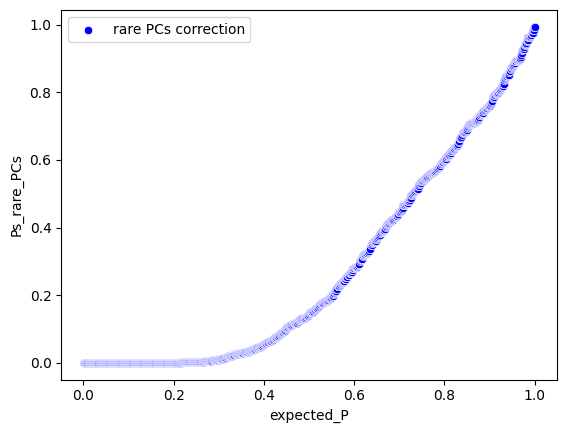

In [28]:
sns.scatterplot(x='expected_P', y='Ps_rare_PCs', data=rare_PCs_df, color='blue', label='rare PCs correction')

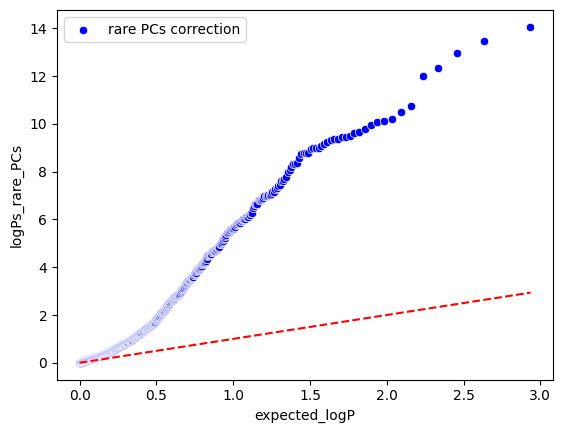

In [29]:
sns.scatterplot(x='expected_logP', y='logPs_rare_PCs', data=rare_PCs_df, color='blue', label='rare PCs correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# PC correction

In [30]:
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [31]:
Ps_common_PC = []
intercepts_common_PC = []
snps_common_PC = []
AFs_common_PC = []
coefs_common_PC = []
faulty_snps_common_PC = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, np.array(PC_common[pc_columns])))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_common_PC.append(p_values)
        snps_common_PC.append(snp.split("_AF_")[0])
        AFs_common_PC.append(snp.split("_AF_")[1])
        coefs_common_PC.append(beta_hat)
    except Exception as e:
        faulty_snps_common_PC.append(snp)
        print(e)

In [32]:
Ps_common_PC = np.sort(Ps_common_PC)
epsilon = 1e-100
logPs_common_PCs = np.sort(-np.log10(Ps_common_PC+epsilon))
common_PCs_df = pd.DataFrame({'coeff':coefs_common_PC, "AFs":AFs_common_PC, "Ps_common_PCs": Ps_common_PC})
n = len(common_PCs_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
common_PCs_df['expected_P'] = expected_quantiles
common_PCs_df['logPs_common_PCs'] = logPs_common_PCs
common_PCs_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_common_PCs'>

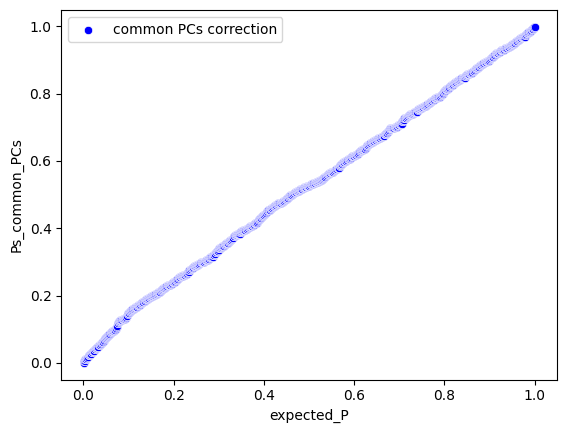

In [33]:
sns.scatterplot(x='expected_P', y='Ps_common_PCs', data=common_PCs_df, color='blue', label='common PCs correction')

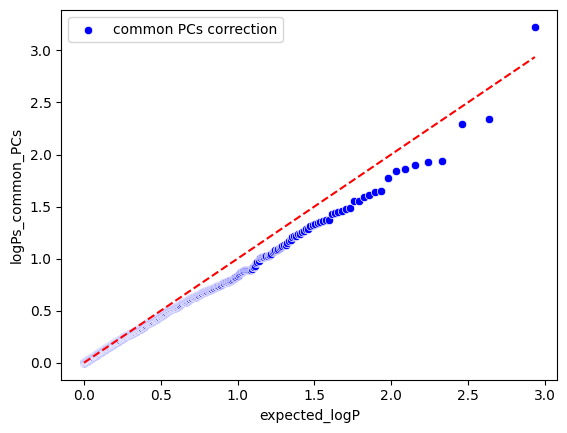

In [34]:
sns.scatterplot(x='expected_logP', y='logPs_common_PCs', data=common_PCs_df, color='blue', label='common PCs correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# Genomic control correction

In [35]:
#Ps_no_corr = []
#snps_no_corr = []
#coefs_no_corr = []
#intercepts_no_corr = []
#faulty_snps_no_corr = []
#AFs_no_corr = []

In [36]:
median_chi2 = np.median(stats.chi2.ppf(1 - Ps_no_corr, 1))
expected_median = stats.chi2.ppf(0.5, 1)
lambda_gc = median_chi2 / expected_median

In [37]:
lambda_gc

9.195972793238807

In [38]:
# Convert p-values to chi-square statistics
chi2_values = stats.chi2.isf(Ps_no_corr, df=1)

# Adjust chi-square statistics
chi2_corr = chi2_values / lambda_gc

# Convert adjusted chi-square statistics back to p-values
p_adjusted = stats.chi2.sf(chi2_corr, df=1)

In [39]:
Ps_GC = np.sort(p_adjusted)
epsilon = 1e-100
logPs_GC = np.sort(-np.log10(Ps_GC+epsilon))
GC_df = pd.DataFrame({'coeff':coefs_no_corr, "AFs":AFs_no_corr, "Ps_GC": Ps_GC})
n = len(GC_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
GC_df['expected_P'] = expected_quantiles
GC_df['logPs_GC'] = logPs_GC
GC_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_GC'>

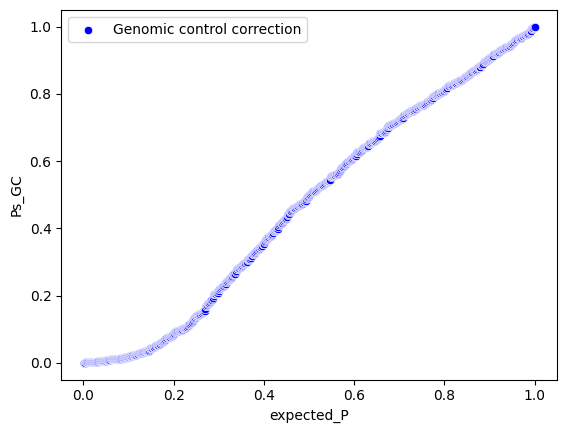

In [40]:
sns.scatterplot(x='expected_P', y='Ps_GC', data=GC_df, color='blue', label='Genomic control correction')

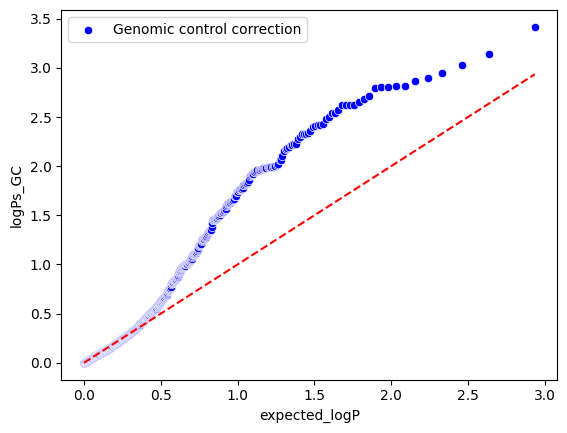

In [41]:
sns.scatterplot(x='expected_logP', y='logPs_GC', data=GC_df, color='blue', label='Genomic control correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# Create Abyss classic

In [42]:
complete
geno = complete*2 - 1

In [43]:
bottleneck_nr = 2
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)

# Regularization parameter
l2_regularizer = 0.001

# Original autoencoder model with L2 regularization
autoencoder = tf.keras.Sequential([
    tf.keras.layers.Dense(bottleneck_nr, activation='linear', name='bottleneck', input_shape=(geno.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
    BatchNormalization(),
    tf.keras.layers.Activation('linear'),
    tf.keras.layers.Dense(geno.shape[1], activation='linear', kernel_regularizer=regularizers.l2(l2_regularizer))
])

# Compile the original model with L2 regularization
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['mean_absolute_error'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the original model with Early Stopping
history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Extract the bottleneck layer
bottleneck_model = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)

# Get bottleneck layer activations for train and test data
X_train_bottleneck = bottleneck_model.predict(X_train)
X_test_bottleneck = bottleneck_model.predict(X_test)

# Evaluate the original model on the test set
test_loss, test_acc = autoencoder.evaluate(X_test, y_test)


125/125 [==============================] - 0s 2ms/step - loss: 0.3032 - mean_absolute_error: 0.3426


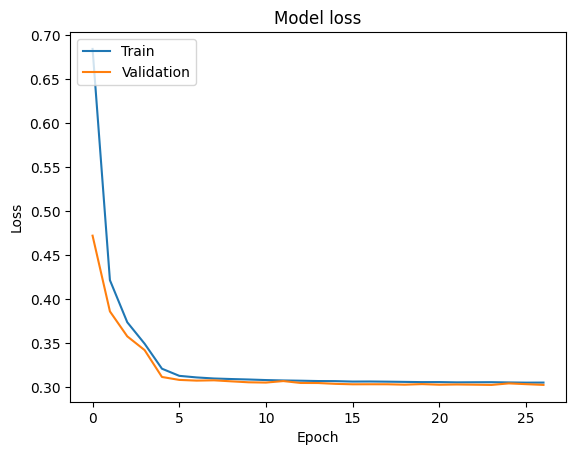

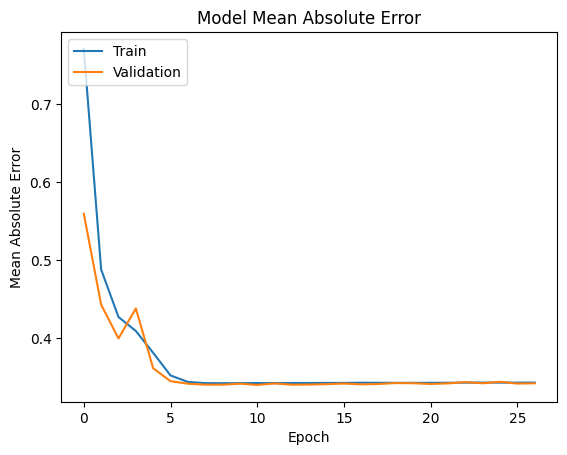

Test Loss: 0.30320343375205994
Test MAE: 0.3426175117492676


In [45]:
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy (if applicable)
    if 'mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'])
        plt.plot(history.history['val_mean_absolute_error'])
        plt.title('Model Mean Absolute Error')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    # Print test loss and accuracy
    print(f"Test Loss: {test_loss}")
    print(f"Test MAE: {test_acc}")

In [46]:
tensor_geno= tf.convert_to_tensor(geno, dtype=tf.float32)
probmaf = (pd.DataFrame(data=autoencoder(tensor_geno), columns = geno.columns)+1)/2
probmaf = 1-probmaf

In [47]:
estimated_AF = probmaf.mean(axis=0)
AFs = [float(item.split('_')[-1]) for item in list(geno.columns)]

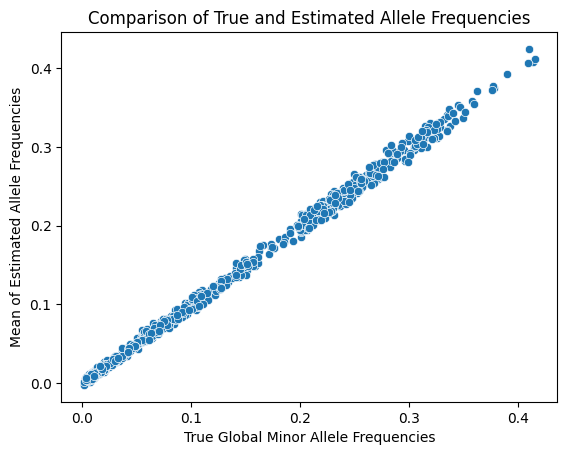

In [48]:
sns.scatterplot(x=AFs, y=list(estimated_AF))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies')
plt.show()

## Check the bottleneck

In [49]:
# Load populations
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

In [50]:
# Obtain the bottleneck outputs
AE_bottle = bottleneck_model.predict(tensor_geno)
AE_bottle

625/625 [==============================] - 1s 1ms/step


array([[-1.3420103,  1.4560994],
       [-1.3559994,  1.4513217],
       [-1.35346  ,  1.460734 ],
       ...,
       [ 1.5035213, -1.3494508],
       [ 1.5093088, -1.3567619],
       [ 1.503781 , -1.3661735]], dtype=float32)

In [51]:
bottle = pd.DataFrame(AE_bottle, columns=dim_columns)
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle[to_have_collumns] = populations[to_have_collumns]

In [52]:
populations

,populations,x,y,z,population_number,population
0,pop 1,1,1,0.5,1,0.0025
1,pop 1,1,1,0.5,1,0.0025
2,pop 1,1,1,0.5,1,0.0025
3,pop 1,1,1,0.5,1,0.0025
4,pop 1,1,1,0.5,1,0.0025
...,...,...,...,...,...,...
19995,pop 400,20,20,0.5,400,1.0000
19996,pop 400,20,20,0.5,400,1.0000
19997,pop 400,20,20,0.5,400,1.0000
19998,pop 400,20,20,0.5,400,1.0000


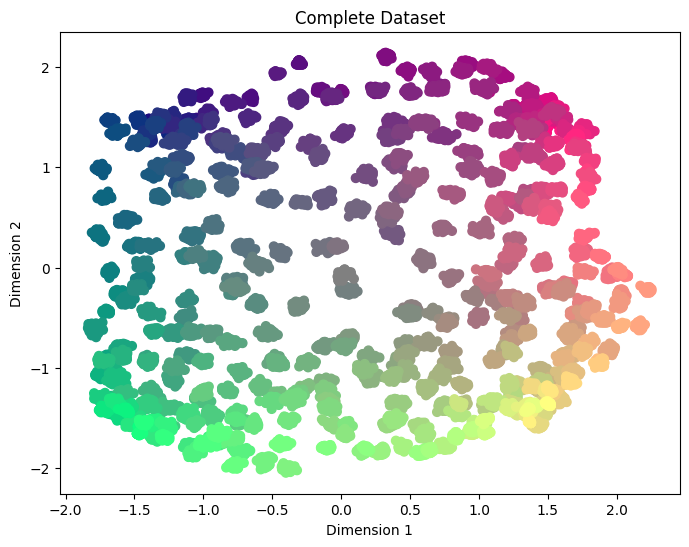

In [53]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle) for x, y, z in zip(bottle['x'], bottle['y'], bottle['z'])]
plt.scatter(x=bottle['dim1'], y=bottle['dim2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

# Correction abyss bottleneck

In [54]:
Ps_abyss_bottle = []
intercepts_abyss_bottle = []
snps_abyss_bottle = []
AFs_abyss_bottle = []
coefs_abyss_bottle = []
faulty_snps_abyss_bottle = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, np.array(AE_bottle)))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_abyss_bottle.append(p_values)
        snps_abyss_bottle.append(snp.split("_AF_")[0])
        AFs_abyss_bottle.append(snp.split("_AF_")[1])
        coefs_abyss_bottle.append(beta_hat)
    except Exception as e:
        faulty_snps_abyss_bottle.append(snp)
        print(e)

In [55]:
Ps_abyss_bottle = np.sort(Ps_abyss_bottle)
epsilon = 1e-100
logPs_abyss_bottle = np.sort(-np.log10(Ps_abyss_bottle+epsilon))
abyss_bottle_df = pd.DataFrame({'coeff':coefs_abyss_bottle, "AFs":AFs_abyss_bottle, "Ps_abyss_bottle": Ps_abyss_bottle})
n = len(abyss_bottle_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
abyss_bottle_df['expected_P'] = expected_quantiles
abyss_bottle_df['logPs_abyss_bottle'] = logPs_abyss_bottle
abyss_bottle_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_abyss_bottle'>

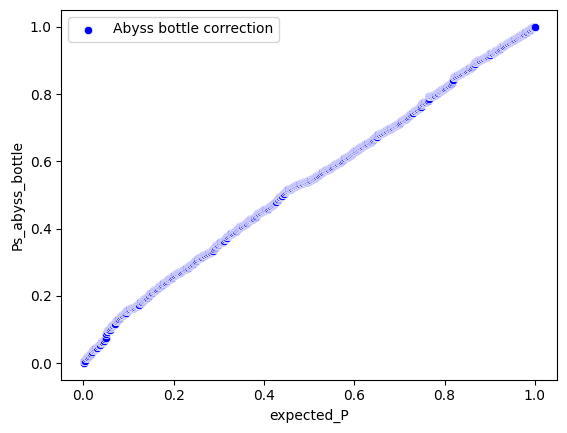

In [56]:
sns.scatterplot(x='expected_P', y='Ps_abyss_bottle', data=abyss_bottle_df, color='blue', label='Abyss bottle correction')

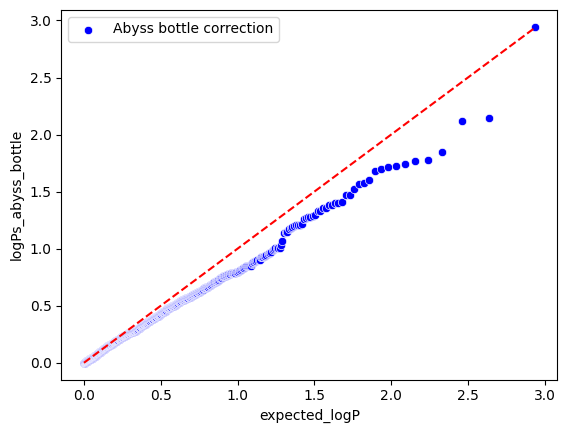

In [57]:
sns.scatterplot(x='expected_logP', y='logPs_abyss_bottle', data=abyss_bottle_df, color='blue', label='Abyss bottle correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# correction abyss maf

In [58]:
Ps_abyss_maf = []
intercepts_abyss_maf = []
snps_abyss_maf = []
AFs_abyss_maf = []
coefs_abyss_maf = []
faulty_snps_abyss_maf = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, np.array(probmaf[snp])))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_abyss_maf.append(p_values)
        snps_abyss_maf.append(snp.split("_AF_")[0])
        AFs_abyss_maf.append(snp.split("_AF_")[1])
        coefs_abyss_maf.append(beta_hat)
    except Exception as e:
        faulty_snps_abyss_maf.append(snp)
        print(e)

In [59]:
Ps_abyss_maf = np.sort(Ps_abyss_maf)
epsilon = 1e-100
logPs_abyss_maf = np.sort(-np.log10(Ps_abyss_maf+epsilon))
abyss_maf_df = pd.DataFrame({'coeff':coefs_abyss_maf, "AFs":AFs_abyss_maf, "Ps_abyss_maf": Ps_abyss_maf})
n = len(abyss_maf_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
abyss_maf_df['expected_P'] = expected_quantiles
abyss_maf_df['logPs_abyss_maf'] = logPs_abyss_maf
abyss_maf_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_abyss_maf'>

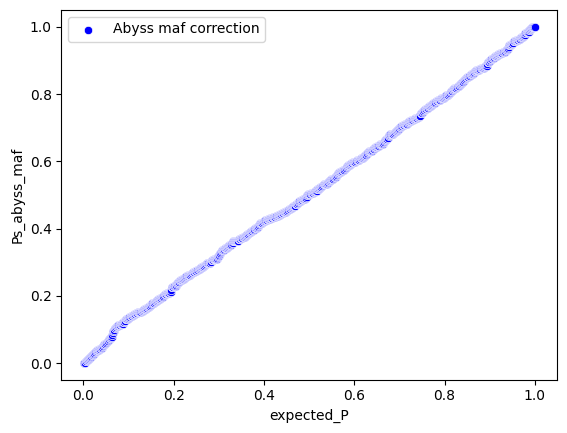

In [60]:
sns.scatterplot(x='expected_P', y='Ps_abyss_maf', data=abyss_maf_df, color='blue', label='Abyss maf correction')

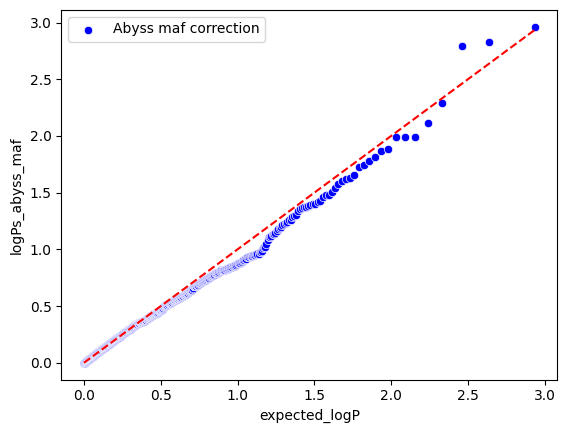

In [61]:
sns.scatterplot(x='expected_logP', y='logPs_abyss_maf', data=abyss_maf_df, color='blue', label='Abyss maf correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# Create Abyss deep

In [62]:
pheno = risk[[name_risk]]

In [64]:
epochs = 50
bottle = 24

dim_columns = ['dim{}'.format(i) for i in range(1, bottle+1)]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, pheno_train, pheno_test = train_test_split(geno, geno, pheno[[name_risk]], test_size=0.2, random_state=42)

# Define your regularization strength (lambda)
l2_lambda = 0.001  # Adjust this value as needed

# Define input layers
input_shape_geno = geno.shape[1:]
input_layer_geno = Input(shape=input_shape_geno, name='input_geno')

input_shape_pheno = pheno.shape[1:]
input_layer_pheno = Input(shape=input_shape_pheno, name='input_pheno')

# Define bottleneck size

size_layer_1 = int(round(input_shape_geno[0]) / 2)

# Create layers
encoder_init_1 = layers.Dense(bottle, 
                       activation="elu", 
                       name="encoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_2 = layers.Dense(input_shape_geno[0], 
                       activation="elu", 
                       name="decoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

predictor = layers.Dense(input_shape_pheno[0], 
                       activation="linear", 
                       name="predictor",
                       kernel_regularizer=regularizers.l2(l2_lambda))

# Define custom layer for element-wise trainable weights
class ElementWiseWeightsLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ElementWiseWeightsLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(), initializer="ones", trainable=True, name="element_wise_weight")
        super(ElementWiseWeightsLayer, self).build(input_shape)

    def call(self, inputs):
        return inputs * self.weight

# Define encoder and decoder paths
bottle_neck = encoder_init_1(input_layer_geno)
allele_frequency_probability = decoder_init_2(bottle_neck)
y_predictor = predictor(allele_frequency_probability)

# Define the model
autoencoder = Model(inputs=input_layer_geno, outputs=[allele_frequency_probability, y_predictor], name="fishy")
# Extract the bottleneck layer
bottleneck_model = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder_init_1').output)

# Compile the model
autoencoder.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[1.0, 2.0])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

# Train the model
history = autoencoder.fit(X_train, [X_train, pheno_train], epochs=epochs, batch_size=32, validation_data=(X_test, [X_test, pheno_test]), callbacks=[early_stopping], verbose=0)

# Evaluate the model
evaluation = autoencoder.evaluate(X_test, [y_test, pheno_test])

# Predict outputs
allele_frequency_output, y_output = autoencoder.predict(geno)

# Extract encoded outputs from the encoder (bottleneck layer)
encoded_output = bottleneck_model.predict(geno)


625/625 [==============================] - 1s 1ms/step


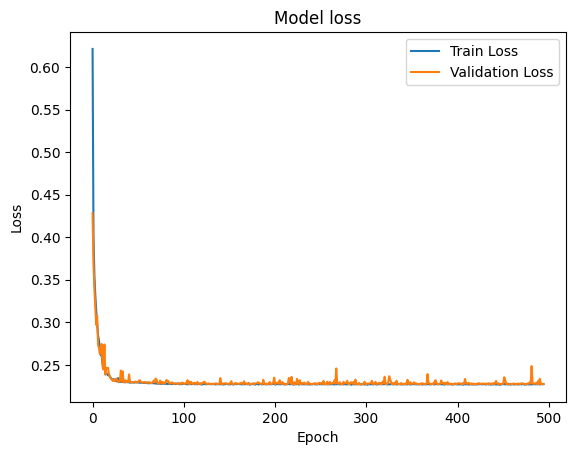

In [65]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [66]:
probmaf = (pd.DataFrame(data=allele_frequency_output, columns = geno.columns)+1)/2
probmaf = 1-probmaf
estimated_AF = probmaf.mean(axis=0)
AFs = [float(item.split('_')[-1]) for item in list(geno.columns)]

# Check maf

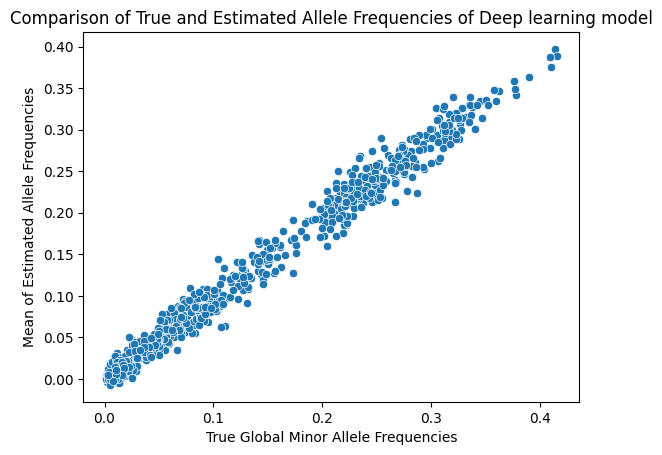

In [67]:
sns.scatterplot(x=AFs, y=list(estimated_AF))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies of Deep learning model')
plt.show()

# Check bottleneck

In [68]:
bottle_df = pd.DataFrame(encoded_output, columns=dim_columns)
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle_df[to_have_collumns] = populations[to_have_collumns]

In [69]:
bottle_df

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim21,dim22,dim23,dim24,populations,population_number,x,y,z,population
0,-0.147347,0.185918,0.355307,1.830014,-0.052390,1.920975,0.752547,-0.050901,3.370287,1.182686,...,4.914068,0.406937,1.519011,-0.138481,pop 1,1,1,1,0.5,0.0025
1,-0.177718,0.060382,0.377239,1.804402,0.031658,1.895808,0.732821,-0.090556,3.289236,1.087072,...,4.918696,0.376271,1.431540,-0.110507,pop 1,1,1,1,0.5,0.0025
2,-0.185779,0.173317,0.428977,1.823043,0.018484,1.931081,0.740293,-0.052626,3.385161,1.131904,...,4.944582,0.403599,1.486920,-0.134449,pop 1,1,1,1,0.5,0.0025
3,-0.142086,0.190053,0.353909,1.829122,-0.044394,1.920402,0.751699,-0.048654,3.366523,1.196485,...,4.900470,0.406660,1.520550,-0.136709,pop 1,1,1,1,0.5,0.0025
4,-0.185779,0.173317,0.428977,1.823043,0.018484,1.931081,0.740293,-0.052626,3.385161,1.131904,...,4.944582,0.403599,1.486920,-0.134449,pop 1,1,1,1,0.5,0.0025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.227190,1.177791,0.299520,4.510676,0.108728,0.278704,-0.327767,5.088958,-0.409607,0.282157,...,0.409233,0.582047,-0.343445,-0.252612,pop 400,400,20,20,0.5,1.0000
19996,0.286676,1.207466,0.321121,4.526334,-0.048306,0.274154,-0.347178,5.106164,-0.358138,0.284882,...,0.471541,0.549677,-0.433154,-0.242059,pop 400,400,20,20,0.5,1.0000
19997,0.229138,1.229203,0.274935,4.437263,-0.008277,0.214914,-0.325319,5.145426,-0.373982,0.308747,...,0.456057,0.544046,-0.403518,-0.274773,pop 400,400,20,20,0.5,1.0000
19998,0.196714,1.255074,0.321214,4.433240,-0.013491,0.207073,-0.331374,5.123404,-0.358425,0.352609,...,0.482555,0.490959,-0.428670,-0.257592,pop 400,400,20,20,0.5,1.0000


In [70]:
from scipy.stats import entropy
# Function to calculate entropy of a column
def calculate_entropy(column):
    counts = column.value_counts()
    return entropy(counts)

temp = bottle_df.round(2)
# Calculate entropy for each column
entropy_values = temp.apply(calculate_entropy)

# Rank the columns based on entropy
ranked_columns_entropy = entropy_values.sort_values(ascending=False)

In [71]:
most_explaining_dims = ranked_columns_entropy.keys()

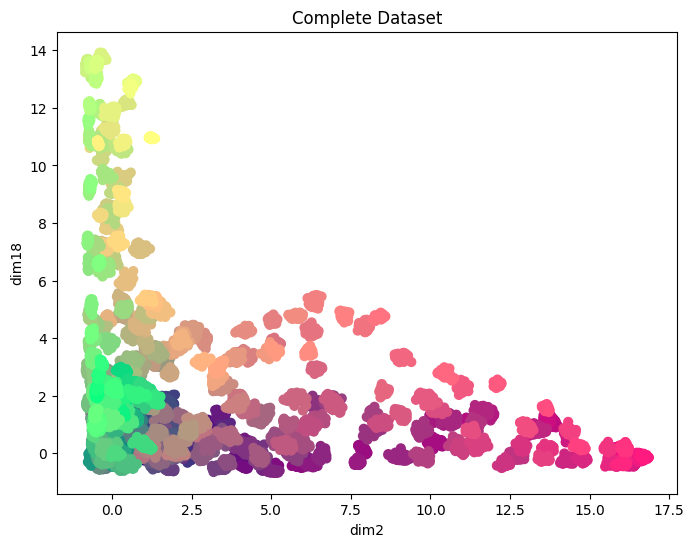

In [72]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[0]], y=bottle_df[most_explaining_dims[1]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[0]}")
plt.ylabel(f"{most_explaining_dims[1]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

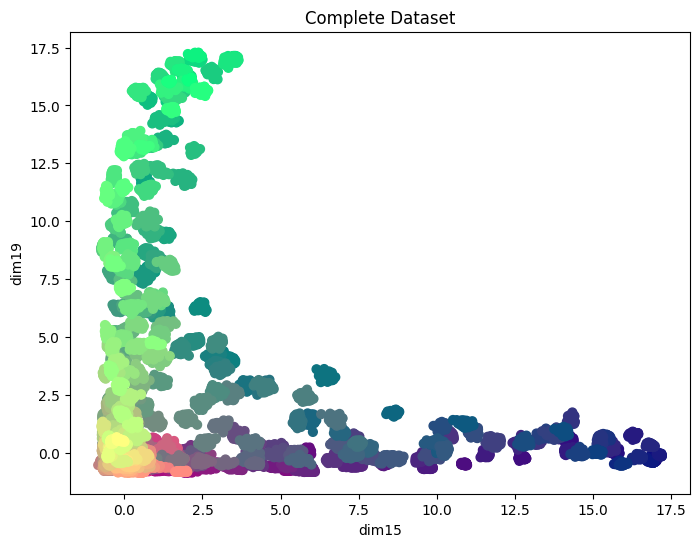

In [73]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df[most_explaining_dims[2]], y=bottle_df[most_explaining_dims[3]], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel(f"{most_explaining_dims[2]}")
plt.ylabel(f"{most_explaining_dims[3]}")

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

# check output

In [74]:
pheno[name_risk]

0        0.25
1        0.25
2        0.25
3        0.25
4        0.25
         ... 
19995    0.25
19996    0.25
19997    0.25
19998    0.25
19999    0.25
Name: NW_risk, Length: 20000, dtype: float64

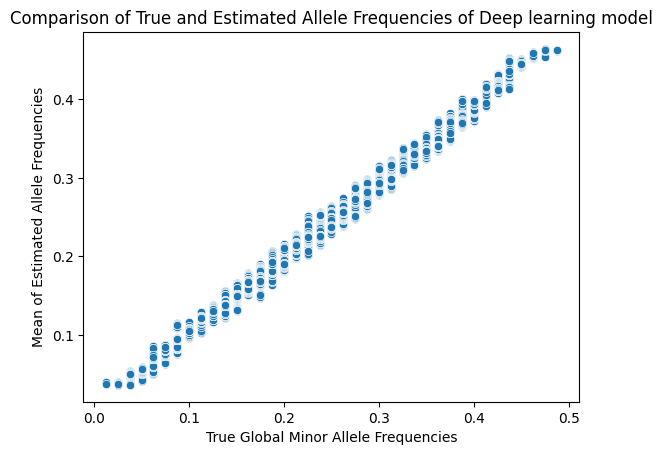

In [75]:
sns.scatterplot(x=list(pheno[name_risk]), y=list(y_output.flatten().tolist()))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies of Deep learning model')
plt.show()

In [76]:
pheno_train

,NW_risk
5894,0.1000
3728,0.1125
8958,0.1125
7671,0.1750
5999,0.0750
...,...
11284,0.3250
11964,0.1500
5390,0.2250
860,0.0375


# Correction deep abyss bottleneck

In [77]:
X_snp

array([1., 1., 1., ..., 1., 1., 1.])

In [78]:
X = np.column_stack((X_snp, np.array(encoded_output)))
#X = sm.add_constant(X)

In [79]:
y

array([-0.72141503, -1.63392454,  1.69224713, ..., -0.71129451,
       -0.51258674,  0.04775355])

In [80]:
X

array([[ 1.        , -0.14734697,  0.18591845, ...,  0.40693673,
         1.51901054, -0.13848054],
       [ 1.        , -0.1777178 ,  0.06038225, ...,  0.37627077,
         1.43153954, -0.11050683],
       [ 1.        , -0.18577874,  0.17331707, ...,  0.4035992 ,
         1.48692012, -0.13444948],
       ...,
       [ 1.        ,  0.22913799,  1.22920275, ...,  0.54404575,
        -0.4035185 , -0.27477306],
       [ 1.        ,  0.19671422,  1.25507414, ...,  0.49095917,
        -0.42866987, -0.25759214],
       [ 1.        ,  0.28667647,  1.20746565, ...,  0.5496766 ,
        -0.43315446, -0.24205863]])

In [81]:
Ps_deep_abyss_bottle = []
intercepts_deep_abyss_bottle = []
snps_deep_abyss_bottle = []
AFs_deep_abyss_bottle = []
coefs_deep_abyss_bottle = []
faulty_snps_deep_abyss_bottle = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, np.array(encoded_output)))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_deep_abyss_bottle.append(p_values)
        snps_deep_abyss_bottle.append(snp.split("_AF_")[0])
        AFs_deep_abyss_bottle.append(snp.split("_AF_")[1])
        coefs_deep_abyss_bottle.append(beta_hat)
    except Exception as e:
        faulty_snps_deep_abyss_bottle.append(snp)
        print(e)

In [82]:
Ps_deep_abyss_bottle = np.sort(Ps_deep_abyss_bottle)
epsilon = 1e-100
logPs_deep_abyss_bottle = np.sort(-np.log10(Ps_deep_abyss_bottle+epsilon))
deep_abyss_bottle_df = pd.DataFrame({'coeff':coefs_deep_abyss_bottle, "AFs":AFs_deep_abyss_bottle, "Ps_abyss_bottle": Ps_deep_abyss_bottle})
n = len(deep_abyss_bottle_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
deep_abyss_bottle_df['expected_P'] = expected_quantiles
deep_abyss_bottle_df['logPs_deep_abyss_bottle'] = logPs_deep_abyss_bottle
deep_abyss_bottle_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_abyss_bottle'>

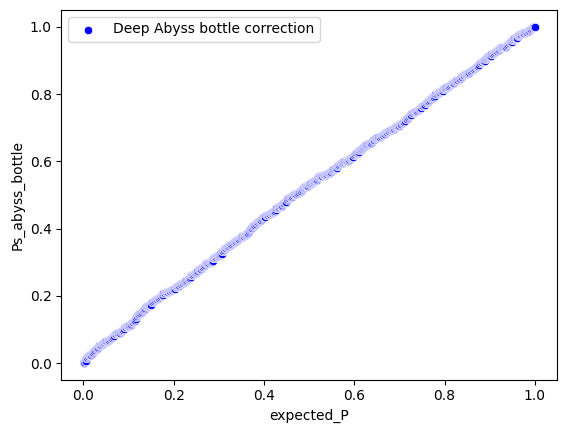

In [83]:
sns.scatterplot(x='expected_P', y='Ps_abyss_bottle', data=deep_abyss_bottle_df, color='blue', label='Deep Abyss bottle correction')

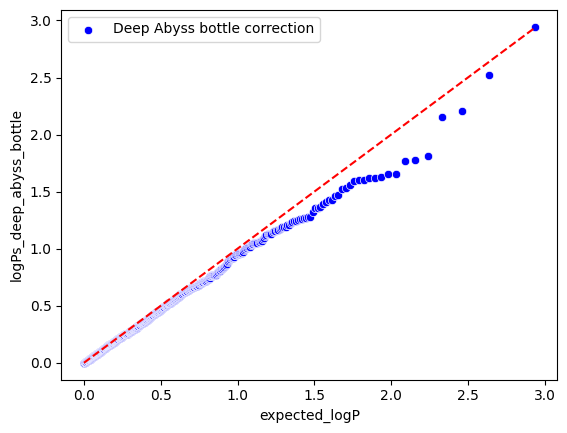

In [84]:
sns.scatterplot(x='expected_logP', y='logPs_deep_abyss_bottle', data=deep_abyss_bottle_df, color='blue', label='Deep Abyss bottle correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# Correction deep abyss MAF

In [85]:
Ps_deep_abyss_maf = []
intercepts_deep_abyss_maf = []
snps_deep_abyss_maf = []
AFs_deep_abyss_maf = []
coefs_deep_abyss_maf = []
faulty_snps_deep_abyss_maf = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, np.array(probmaf[snp])))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_deep_abyss_maf.append(p_values)
        snps_deep_abyss_maf.append(snp.split("_AF_")[0])
        AFs_deep_abyss_maf.append(snp.split("_AF_")[1])
        coefs_deep_abyss_maf.append(beta_hat)
    except Exception as e:
        faulty_snps_deep_abyss_maf.append(snp)
        print(e)

In [86]:
Ps_deep_abyss_maf = np.sort(Ps_deep_abyss_maf)
epsilon = 1e-100
logPs_deep_abyss_maf = np.sort(-np.log10(Ps_deep_abyss_maf+epsilon))
deep_abyss_maf_df = pd.DataFrame({'coeff':coefs_deep_abyss_maf, "AFs":AFs_deep_abyss_maf, "Ps_abyss_maf": Ps_deep_abyss_maf})
n = len(deep_abyss_maf_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
deep_abyss_maf_df['expected_P'] = expected_quantiles
deep_abyss_maf_df['logPs_deep_abyss_maf'] = logPs_deep_abyss_maf
deep_abyss_maf_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_abyss_maf'>

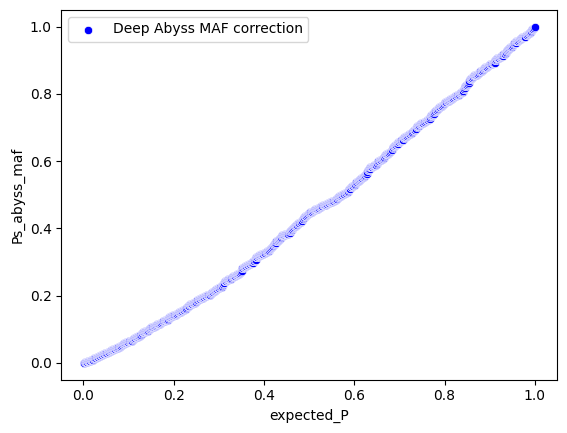

In [87]:
sns.scatterplot(x='expected_P', y='Ps_abyss_maf', data=deep_abyss_maf_df, color='blue', label='Deep Abyss MAF correction')

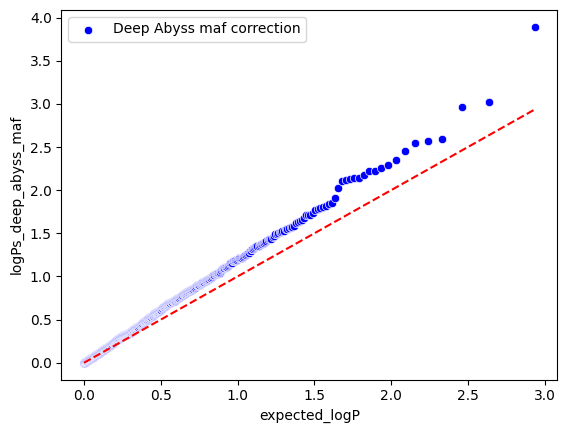

In [88]:
sns.scatterplot(x='expected_logP', y='logPs_deep_abyss_maf', data=deep_abyss_maf_df, color='blue', label='Deep Abyss maf correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# Pred correction

In [89]:
Ps_deep_abyss_pred = []
intercepts_deep_abyss_pred = []
snps_deep_abyss_pred = []
AFs_deep_abyss_pred = []
coefs_deep_abyss_pred = []
faulty_snps_deep_abyss_pred = []

for snp in list(complete.columns):
    index_to_keep = snp.split("_AF_")[0]
    X_snp = np.array(list(complete[snp]))
    X = np.column_stack((X_snp, y_output.flatten()))
    X = sm.add_constant(X)
    try:
        #intercept, beta_hat, se_beta, t_values, p_values = lin_reg(pheno, geno)
        model = sm.OLS(y, X).fit()
        p_values = model.pvalues[1]
        betas = model.params[1:]
        beta_hat = betas[0]
        se_beta = model.bse[1]
        t_values = model.tvalues[1]
        Ps_deep_abyss_pred.append(p_values)
        snps_deep_abyss_pred.append(snp.split("_AF_")[0])
        AFs_deep_abyss_pred.append(snp.split("_AF_")[1])
        coefs_deep_abyss_pred.append(beta_hat)
    except Exception as e:
        faulty_snps_deep_abyss_pred.append(snp)
        print(e)

In [90]:
Ps_deep_abyss_pred = np.sort(Ps_deep_abyss_pred)
epsilon = 1e-100
logPs_deep_abyss_pred = np.sort(-np.log10(Ps_deep_abyss_pred+epsilon))
deep_abyss_pred_df = pd.DataFrame({'coeff':coefs_deep_abyss_pred, "AFs":AFs_deep_abyss_pred, "Ps_abyss_pred": Ps_deep_abyss_pred})
n = len(deep_abyss_pred_df)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles+epsilon))
deep_abyss_pred_df['expected_P'] = expected_quantiles
deep_abyss_pred_df['logPs_deep_abyss_pred'] = logPs_deep_abyss_pred
deep_abyss_pred_df['expected_logP'] = expected_logP

<Axes: xlabel='expected_P', ylabel='Ps_abyss_pred'>

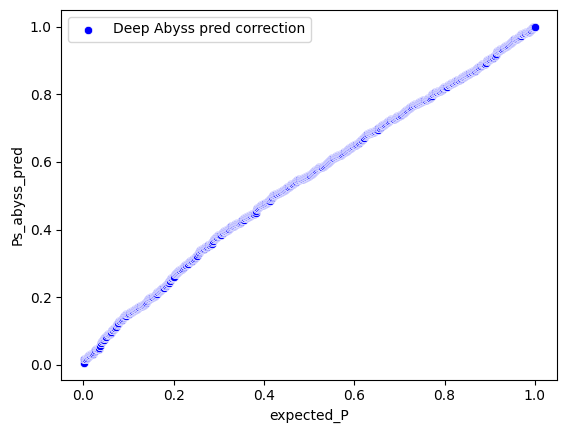

In [91]:
sns.scatterplot(x='expected_P', y='Ps_abyss_pred', data=deep_abyss_pred_df, color='blue', label='Deep Abyss pred correction')

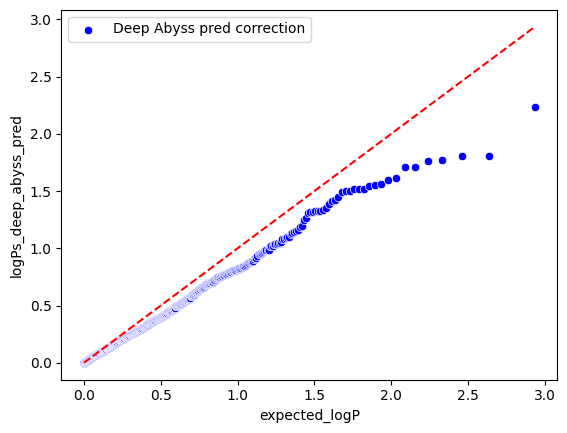

In [92]:
sns.scatterplot(x='expected_logP', y='logPs_deep_abyss_pred', data=deep_abyss_pred_df, color='blue', label='Deep Abyss pred correction')
# Plot diagonal reference line
plt.plot([min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         [min(rare_PCs_df['expected_logP']), max(rare_PCs_df['expected_logP'])], 
         color='red', linestyle='--')

# Abyss looping

In [16]:
nr_dims

[0, 1]

In [17]:
nr_dims = list(range(2))
geno = complete*2 - 1
pheno = risk[[name_risk]]
input_shape_geno = geno.shape
input_shape_pheno = pheno.shape

In [19]:
AE_dims = pd.DataFrame()

os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)
epochs = 30
bottle = 1

maf_line = pd.DataFrame(np.zeros(geno.shape))
maf_line.columns = geno.columns

for dim_nr in nr_dims:


    # Define the model with an additional bottleneck output
    dim_columns = ['dim{}'.format(i) for i in range(1, bottle+1)]
    # Split the data into training and testing sets
    maf_line_train, maf_line_test, X_train, X_test, pheno_train, pheno_test = train_test_split(maf_line, geno, pheno[[name_risk]], test_size=0.2, random_state=42)
    
    # Define your regularization strength (lambda)
    l2_lambda = 0 # Adjust this value as needed
    
    # Define input layers
    input_shape_geno = geno.shape[1:]
    input_layer_geno = Input(shape=input_shape_geno, name='input_geno')

    input_shape_maf = maf_line.shape[1:]
    input_layer_maf = Input(shape=input_shape_maf, name='input_mafline')

    input_shape_pheno = pheno.shape[1:]
    input_layer_pheno = Input(shape=input_shape_pheno, name='input_pheno')
    
    # Define bottleneck size
    bottle = 1
    
    # Create layers
    encoder_init_1 = layers.Dense(bottle, 
                               activation="elu", 
                               name="encoder_init_1",
                               kernel_regularizer=regularizers.l2(l2_lambda))
        
    decoder_init_2 = layers.Dense(input_shape_geno[0], 
                               activation="elu", 
                               name="decoder_init_2",
                               kernel_regularizer=regularizers.l2(l2_lambda))
        
    predictor = layers.Dense(input_shape_pheno[0],
                               activation="linear", 
                               name="predictor",
                               kernel_regularizer=regularizers.l2(l2_lambda))
    
    # Define encoder and decoder paths
    bottleneck = encoder_init_1(input_layer_geno)
    allele_frequency_probability = decoder_init_2(bottleneck)
    updated_allele_frequency = allele_frequency_probability + input_layer_maf
    y_predictor = predictor(updated_allele_frequency)
    
        
    # Create dummy targets for the bottleneck layer (same shape as the bottleneck layer)
    dummy_bottleneck_train = np.zeros((X_train.shape[0], bottle))
    dummy_bottleneck_test = np.zeros((X_test.shape[0], bottle))

    dummy_MAF_train = np.zeros((X_train.shape[0], X_train.shape[1]))
    dummy_MAF_test = np.zeros((X_test.shape[0], X_train.shape[1]))
    
    # Define the model with an additional bottleneck output
    autoencoder = Model(inputs=[input_layer_geno, input_layer_maf], 
                        outputs=[updated_allele_frequency, y_predictor, bottleneck, allele_frequency_probability], 
                        name="fishy")
    
    # Compile the model
    autoencoder.compile(optimizer='adam', 
                        loss=['mse', 'mse', None, None],  # None for the bottleneck output
                        loss_weights=[1.0, 2.0, 0.0, 0.0])  # 0.0 weight to make bottleneck untrainable
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
    
    # Train the model
    history = autoencoder.fit([X_train, maf_line_train], 
                              [X_train, pheno_train, dummy_bottleneck_train, dummy_MAF_train],  # Dummy target for the bottleneck
                              epochs=epochs, 
                              batch_size=32, 
                              validation_data=([X_test, maf_line_test], 
                                               [X_test, pheno_test, dummy_bottleneck_test, dummy_MAF_test]),  # Dummy target for the bottleneck
                              callbacks=[early_stopping], 
                              verbose=0)
    
    # Predict using the autoencoder
    updated_allele_frequency, y_predictor_output, bottleneck_output, allele_frequency = autoencoder.predict([geno, maf_line])
    
    # Save outputs as needed
    updated_allele_frequency_df = pd.DataFrame(updated_allele_frequency, columns=geno.columns)
    updated_allele_frequency_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_updated_allele_frequency.pkl")

    # Save outputs as needed
    allele_frequency_df = pd.DataFrame(allele_frequency, columns=geno.columns)
    allele_frequency_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_allele_frequency.pkl")
    
    y_predictor_output_df = pd.DataFrame(y_predictor_output, columns=pheno.columns)
    y_predictor_output_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_y_predictor_output.pkl")
    
    bottleneck_output_df = pd.DataFrame(bottleneck_output, columns=[f"bottleneck_{dim_nr}"])
    AE_dims[f"dim{dim_nr+1}"] = bottleneck_output_df[f"bottleneck_{dim_nr}"]
    bottleneck_output_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_bottleneck_output.pkl")


625/625 [==============================] - 1s 2ms/step


In [20]:
AE_dims

,dim1,dim2,dim3,dim4
0,-0.935584,13.150659,-0.933782,-1.0
1,-0.935468,13.183921,-0.933369,-1.0
2,-0.933218,13.156102,-0.932154,-1.0
3,-0.936933,13.211270,-0.933140,-1.0
4,-0.933218,13.156102,-0.932154,-1.0
...,...,...,...,...
19995,-0.936924,13.220849,-0.928739,-1.0
19996,-0.934713,13.301951,-0.934699,-1.0
19997,-0.937074,13.276889,-0.933669,-1.0
19998,-0.932216,13.206289,-0.930916,-1.0


In [21]:
# Load populations
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

In [22]:
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
AE_dims[to_have_collumns] = populations[to_have_collumns]

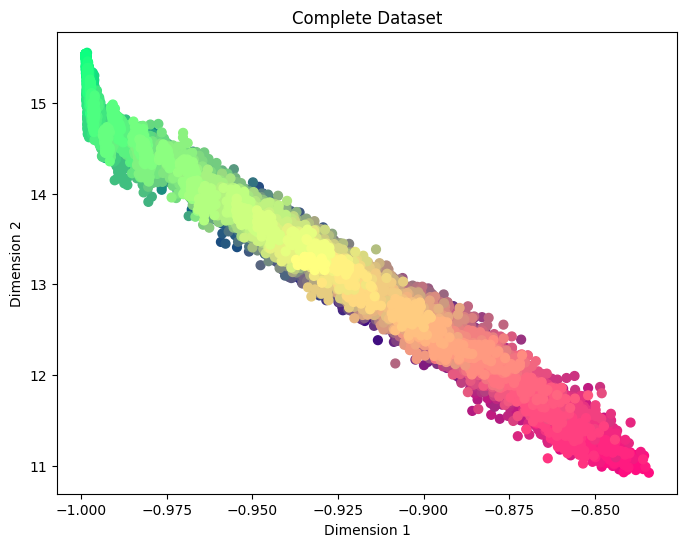

In [40]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = AE_dims['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, AE_dims) for x, y, z in zip(AE_dims['x'], AE_dims['y'], AE_dims['z'])]
plt.scatter(x=AE_dims['dim3'], y=AE_dims['dim2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

In [24]:
files = os.listdir(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/")

In [25]:
files

['1_bottleneck_output.pkl',
 '2_allele_frequency.pkl',
 '3_allele_frequency.pkl',
 '0_allele_frequency.pkl',
 '1_y_predictor_output.pkl',
 '3_bottleneck_output.pkl',
 '2_updated_allele_frequency.pkl',
 '2_bottleneck_output.pkl',
 '0_bottleneck_output.pkl',
 '3_y_predictor_output.pkl',
 '3_updated_allele_frequency.pkl',
 '1_allele_frequency.pkl',
 '2_y_predictor_output.pkl',
 '0_updated_allele_frequency.pkl',
 '0_y_predictor_output.pkl',
 '1_updated_allele_frequency.pkl']

In [26]:
file_list = [f for f in files if f.split("_")[1] == "allele"]
# Sort the list using a custom key function
sorted_list = sorted(file_list, key=lambda x: int(x.split('_')[0]))

In [27]:
sorted_list

['0_allele_frequency.pkl',
 '1_allele_frequency.pkl',
 '2_allele_frequency.pkl',
 '3_allele_frequency.pkl']

In [28]:
for file in sorted_list[0:1]:
    mafss = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{file}")

In [29]:
file

'0_allele_frequency.pkl'

In [30]:
mafss

snps,C0_AF_0.296425,C1_AF_0.21885,C2_AF_0.21275,C3_AF_0.2368,C4_AF_0.217525,C5_AF_0.20005,C6_AF_0.26035,C7_AF_0.3068,C8_AF_0.222275,C9_AF_0.296525,...,VR275_AF_0.0094,VR276_AF_0.00495,VR277_AF_0.0182,VR278_AF_0.008725,VR279_AF_0.003725,VR280_AF_0.016075,VR281_AF_0.0108,VR282_AF_0.008,VR283_AF_0.010525,VR284_AF_0.00345
0,0.404119,0.553372,0.572741,0.526132,0.561042,0.598414,0.467197,0.379918,0.556664,0.412306,...,0.978243,0.986581,0.960651,0.978104,0.989874,0.966197,0.974067,0.980696,0.978423,0.988678
1,0.404070,0.553343,0.572711,0.526105,0.561012,0.598366,0.467178,0.379887,0.556616,0.412292,...,0.978177,0.986515,0.960598,0.978041,0.989812,0.966142,0.974002,0.980645,0.978370,0.988609
2,0.403125,0.552777,0.572122,0.525568,0.560434,0.597419,0.466812,0.379284,0.555666,0.412016,...,0.976886,0.985240,0.959559,0.976824,0.988618,0.965073,0.972736,0.979641,0.977325,0.987271
3,0.404685,0.553712,0.573094,0.526454,0.561388,0.598982,0.467416,0.380279,0.557233,0.412472,...,0.979017,0.987345,0.961274,0.978833,0.990590,0.966837,0.974826,0.981298,0.979050,0.989480
4,0.403125,0.552777,0.572122,0.525568,0.560434,0.597419,0.466812,0.379284,0.555666,0.412016,...,0.976886,0.985240,0.959559,0.976824,0.988618,0.965073,0.972736,0.979641,0.977325,0.987271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.404682,0.553710,0.573092,0.526452,0.561386,0.598978,0.467415,0.380276,0.557230,0.412471,...,0.979012,0.987340,0.961270,0.978828,0.990585,0.966833,0.974821,0.981294,0.979045,0.989475
19996,0.403753,0.553153,0.572513,0.525925,0.560818,0.598048,0.467055,0.379684,0.556297,0.412199,...,0.977744,0.986087,0.960249,0.977633,0.989412,0.965783,0.973577,0.980308,0.978019,0.988161
19997,0.404745,0.553747,0.573131,0.526488,0.561424,0.599041,0.467439,0.380317,0.557293,0.412489,...,0.979098,0.987426,0.961339,0.978909,0.990665,0.966904,0.974906,0.981361,0.979115,0.989564
19998,0.402704,0.552525,0.571860,0.525329,0.560177,0.596998,0.466649,0.379016,0.555244,0.411893,...,0.976312,0.984672,0.959096,0.976282,0.988086,0.964598,0.972173,0.979194,0.976860,0.986676


In [31]:
AE_dims

,dim1,dim2,dim3,dim4,populations,population_number,x,y,z,population
0,-0.935584,13.150659,-0.933782,-1.0,pop 1,1,1,1,0.5,0.0025
1,-0.935468,13.183921,-0.933369,-1.0,pop 1,1,1,1,0.5,0.0025
2,-0.933218,13.156102,-0.932154,-1.0,pop 1,1,1,1,0.5,0.0025
3,-0.936933,13.211270,-0.933140,-1.0,pop 1,1,1,1,0.5,0.0025
4,-0.933218,13.156102,-0.932154,-1.0,pop 1,1,1,1,0.5,0.0025
...,...,...,...,...,...,...,...,...,...,...
19995,-0.936924,13.220849,-0.928739,-1.0,pop 400,400,20,20,0.5,1.0000
19996,-0.934713,13.301951,-0.934699,-1.0,pop 400,400,20,20,0.5,1.0000
19997,-0.937074,13.276889,-0.933669,-1.0,pop 400,400,20,20,0.5,1.0000
19998,-0.932216,13.206289,-0.930916,-1.0,pop 400,400,20,20,0.5,1.0000


In [32]:
nth_column_df = mafss.iloc[:, [0]]

In [33]:
test = pd.DataFrame()
test['maf'] = nth_column_df
test['population line'] = AE_dims['dim1']

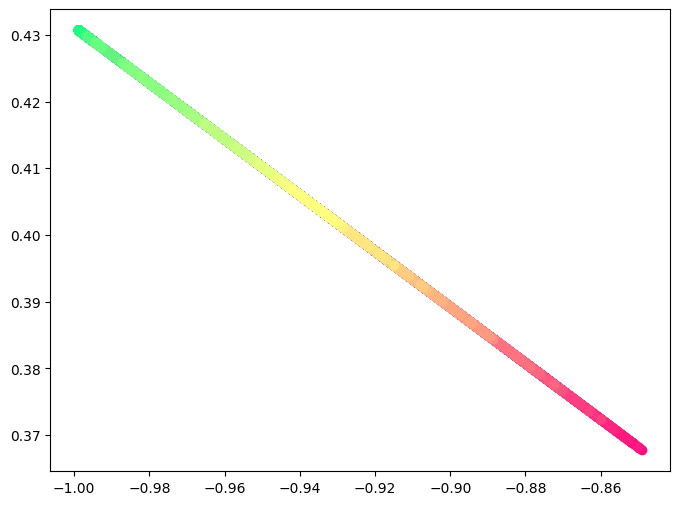

In [34]:
# Create a figure
plt.figure(figsize=(8, 6))
plt.scatter(x=list(test['population line']), y=list(test['maf']), c=colors, s=40)

In [35]:
for file in sorted_list[1:2]:
    mafss2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{file}")

In [48]:
file

'1_allele_frequency.pkl'

In [49]:
nth_column_df2 = mafss2.iloc[:, [0]]

In [50]:
test2 = pd.DataFrame()
test2['maf'] = nth_column_df2
test2['population line'] = AE_dims['dim2']

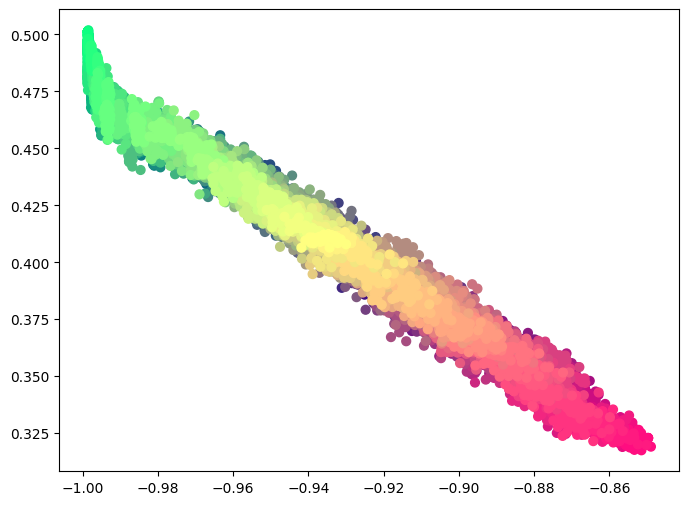

In [51]:
# Create a figure
plt.figure(figsize=(8, 6))
plt.scatter(x=list(test['population line']), y=list(test2['maf']), c=colors, s=40)

In [44]:
mafss3 = mafss - mafss2

In [45]:
nth_column_df3 = mafss3.iloc[:, [0]]

In [46]:
test3 = pd.DataFrame()
test3['maf'] = nth_column_df3
test3['population line'] = AE_dims['dim2']

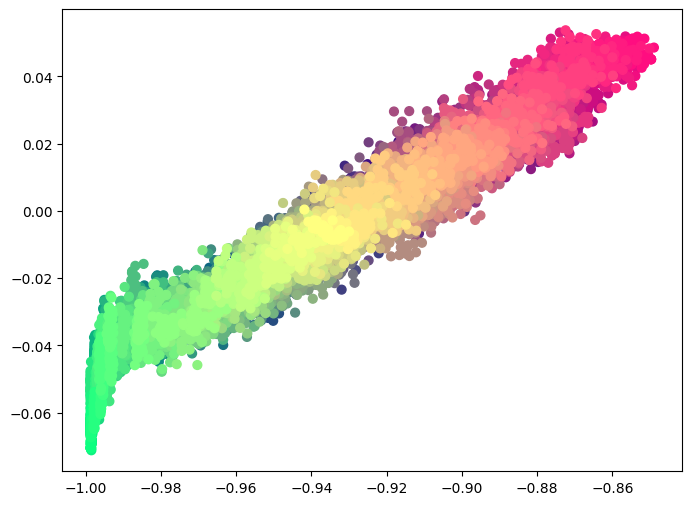

In [47]:
# Create a figure
plt.figure(figsize=(8, 6))
plt.scatter(x=list(test['population line']), y=list(test3['maf']), c=colors, s=40)

In [27]:
AE_dims = pd.DataFrame()

os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)
epochs = 500
bottle = 1

maf_line = pd.DataFrame(np.zeros(geno.shape))
maf_line.columns = geno.columns

for dim_nr in nr_dims:


    # Define the model with an additional bottleneck output
    dim_columns = ['dim{}'.format(i) for i in range(1, bottle+1)]
    # Split the data into training and testing sets
    maf_line_train, maf_line_test, X_train, X_test, pheno_train, pheno_test = train_test_split(maf_line, geno, pheno[[name_risk]], test_size=0.2, random_state=42)
    
    # Define your regularization strength (lambda)
    l2_lambda = 0 # Adjust this value as needed
    
    # Define input layers
    input_shape_geno = geno.shape[1:]
    input_layer_geno = Input(shape=input_shape_geno, name='input_geno')

    input_shape_maf = maf_line.shape[1:]
    input_layer_maf = Input(shape=input_shape_maf, name='input_mafline')

    input_shape_pheno = pheno.shape[1:]
    input_layer_pheno = Input(shape=input_shape_pheno, name='input_pheno')
    
    # Define bottleneck size
    bottle = 1
    
    # Create layers
    encoder_init_1 = layers.Dense(bottle, 
                               activation="elu", 
                               name="encoder_init_1",
                               kernel_regularizer=regularizers.l2(l2_lambda))
        
    decoder_init_2 = layers.Dense(input_shape_geno[0], 
                               activation="elu", 
                               name="decoder_init_2",
                               kernel_regularizer=regularizers.l2(l2_lambda))
        
    predictor = layers.Dense(input_shape_pheno[0],
                               activation="linear", 
                               name="predictor",
                               kernel_regularizer=regularizers.l2(l2_lambda))
    
    # Define encoder and decoder paths
    bottleneck = encoder_init_1(input_layer_geno)
    allele_frequency_probability = decoder_init_2(bottleneck)
    updated_allele_frequency = allele_frequency_probability + input_layer_maf
    y_predictor = predictor(updated_allele_frequency)
    
        
    # Create dummy targets for the bottleneck layer (same shape as the bottleneck layer)
    dummy_bottleneck_train = np.zeros((X_train.shape[0], bottle))
    dummy_bottleneck_test = np.zeros((X_test.shape[0], bottle))

    dummy_MAF_train = np.zeros((X_train.shape[0], X_train.shape[1]))
    dummy_MAF_test = np.zeros((X_test.shape[0], X_train.shape[1]))
    
    # Define the model with an additional bottleneck output
    autoencoder = Model(inputs=[input_layer_geno, input_layer_maf], 
                        outputs=[updated_allele_frequency, y_predictor, bottleneck], 
                        name="fishy")
    
    # Compile the model
    autoencoder.compile(optimizer='adam', 
                        loss=['mse', 'mse', None, None],  # None for the bottleneck output
                        loss_weights=[1.0, 2.0, 0.0])  # 0.0 weight to make bottleneck untrainable
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    
    # Train the model
    history = autoencoder.fit([X_train, maf_line_train], 
                              [X_train, pheno_train, dummy_bottleneck_train],  # Dummy target for the bottleneck
                              epochs=epochs, 
                              batch_size=32, 
                              validation_data=([X_test, maf_line_test], 
                                               [X_test, pheno_test, dummy_bottleneck_test]),  # Dummy target for the bottleneck
                              callbacks=[early_stopping], 
                              verbose=0)
    
    # Predict using the autoencoder
    # Convert data to tensors
    X1= tf.convert_to_tensor(geno, dtype=tf.float32)
    X2 = tf.convert_to_tensor(maf_line, dtype=tf.float32)
    updated_allele_frequency, y_predictor_output, bottleneck_output = autoencoder([X1, X2])
    # Save outputs as needed
    updated_allele_frequency_df = pd.DataFrame(updated_allele_frequency, columns=geno.columns)
    updated_allele_frequency_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_updated_allele_frequency.pkl")
    
    y_predictor_output_df = pd.DataFrame(y_predictor_output, columns=pheno.columns)
    y_predictor_output_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_y_predictor_output.pkl")
    
    bottleneck_output_df = pd.DataFrame(bottleneck_output, columns=[f"bottleneck_{dim_nr}"])
    AE_dims[f"dim{dim_nr+1}"] = bottleneck_output_df[f"bottleneck_{dim_nr}"]
    bottleneck_output_df.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{dim_nr}_bottleneck_output.pkl")


In [28]:
# Load populations
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
populations['population'] = populations['population_number']/(k*k)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
AE_dims[to_have_collumns] = populations[to_have_collumns]

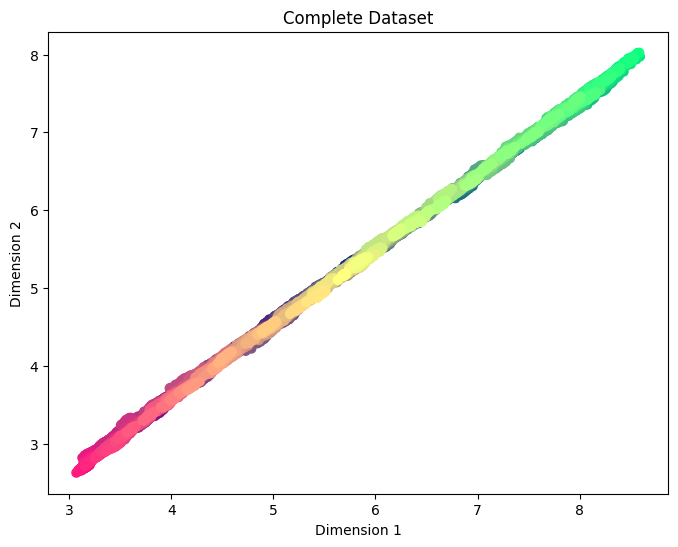

In [29]:
# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = AE_dims['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, AE_dims) for x, y, z in zip(AE_dims['x'], AE_dims['y'], AE_dims['z'])]
plt.scatter(x=AE_dims['dim1'], y=AE_dims['dim2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

In [30]:
files = os.listdir(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/")
files

['1_bottleneck_output.pkl',
 '2_allele_frequency.pkl',
 '3_allele_frequency.pkl',
 '0_allele_frequency.pkl',
 '1_y_predictor_output.pkl',
 '3_bottleneck_output.pkl',
 '2_updated_allele_frequency.pkl',
 '2_bottleneck_output.pkl',
 '0_bottleneck_output.pkl',
 '3_y_predictor_output.pkl',
 '3_updated_allele_frequency.pkl',
 '1_allele_frequency.pkl',
 '2_y_predictor_output.pkl',
 '0_updated_allele_frequency.pkl',
 '0_y_predictor_output.pkl',
 '1_updated_allele_frequency.pkl']

In [44]:
file_list = [f for f in files if f.split("_")[1] == "updated"]
# Sort the list using a custom key function
sorted_list = sorted(file_list, key=lambda x: int(x.split('_')[0]))
sorted_list

['0_updated_allele_frequency.pkl',
 '1_updated_allele_frequency.pkl',
 '2_updated_allele_frequency.pkl',
 '3_updated_allele_frequency.pkl']

In [45]:
for file in sorted_list[0:1]:
    mafss = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{file}")

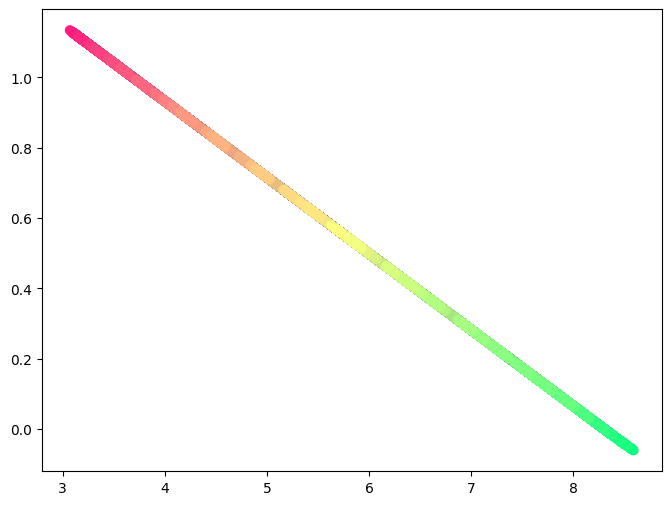

In [46]:
nth_column_df = mafss.iloc[:, [1]]
test = pd.DataFrame()
test['maf'] = nth_column_df
test['population line'] = AE_dims['dim1']
# Create a figure
plt.figure(figsize=(8, 6))
plt.scatter(x=list(test['population line']), y=list(test['maf']), c=colors, s=40)

In [49]:
for file in sorted_list[1:2]:
    mafss = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/{file}")- mafss
file

'1_updated_allele_frequency.pkl'

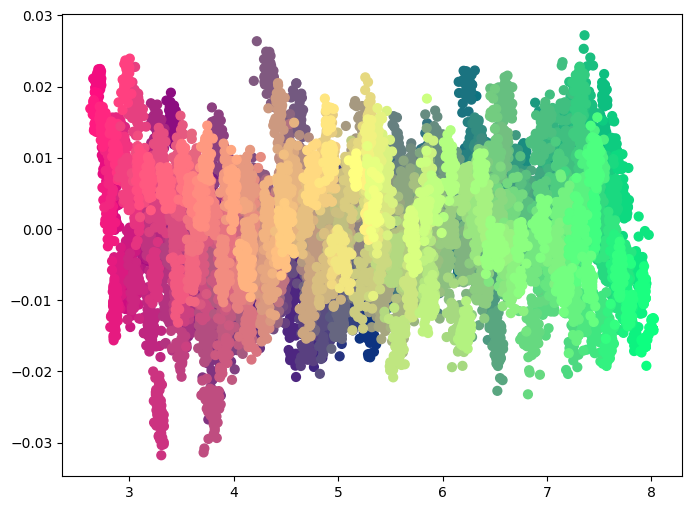

In [50]:
nth_column_df = mafss.iloc[:, [1]]
test = pd.DataFrame()
test['maf'] = nth_column_df
test['population line'] = AE_dims['dim2']
# Create a figure
plt.figure(figsize=(8, 6))
plt.scatter(x=list(test['population line']), y=list(test['maf']), c=colors, s=40)

# Hello

In [14]:
geno.shape

NameError: name 'geno' is not defined

In [ ]:
X_train.shape

In [15]:
X_test.shape

NameError: name 'X_test' is not defined

In [16]:
input_shape_pheno

NameError: name 'input_shape_pheno' is not defined

In [17]:
nr_dims = list(range(2))
geno = complete*2 - 1
pheno = risk[[name_risk]]
input_shape_geno = geno.shape
input_shape_pheno = pheno.shape
X_train, X_test = train_test_split(geno, test_size=0.2, random_state=42)

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Define source autoencoder
input_dim = input_shape_geno[1]  # Example input dimension for an MNIST-like dataset
encoding_dim = 1  # Example encoding dimension

input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

source_autoencoder = Model(input_img, decoded)

# Define target autoencoder (with same architecture for simplicity)
input_img_new = Input(shape=(input_dim,))
encoded_new = Dense(encoding_dim, activation='relu')(input_img_new)
decoded_new = Dense(input_dim, activation='sigmoid')(encoded_new)

target_autoencoder = Model(input_img_new, decoded_new)

In [20]:
# Define target autoencoder (with same architecture for simplicity)
input_img_new = Input(shape=(input_dim,))
encoded_new = Dense(encoding_dim + 1, activation='relu')(input_img_new)
decoded_new = Dense(input_dim, activation='sigmoid')(encoded_new)

target_autoencoder = Model(input_img_new, decoded_new)

In [21]:
# Assuming you have your training data as 'x_train'
source_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
source_autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
63/63 [==============================] - 2s 17ms/step - loss: 0.6173 - val_loss: 0.4954
Epoch 2/50
63/63 [==============================] - 1s 12ms/step - loss: 0.4509 - val_loss: 0.4365
Epoch 3/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4347 - val_loss: 0.4344
Epoch 4/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4336 - val_loss: 0.4339
Epoch 5/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4329 - val_loss: 0.4332
Epoch 6/50
63/63 [==============================] - 1s 12ms/step - loss: 0.4318 - val_loss: 0.4320
Epoch 7/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4298 - val_loss: 0.4302
Epoch 8/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4266 - val_loss: 0.4264
Epoch 9/50
63/63 [==============================] - 1s 11ms/step - loss: 0.4211 - val_loss: 0.4201
Epoch 10/50
63/63 [==============================] - 1s 13ms/step - loss: 0.4116 - val_loss: 0.4096
Epoch 11/

In [40]:
source_autoencoder.layers

In [32]:
sourcelayer1 = source_autoencoder.layers[0]
sourcelayer2 = source_autoencoder.layers[1]
sourcelayer3 = source_autoencoder.layers[2]

In [52]:
target_autoencoder.layers

In [51]:
targetlayer1 = target_autoencoder.layers[0]
targetlayer2 = target_autoencoder.layers[1]
targetlayer3 = target_autoencoder.layers[2]

In [69]:
targetlayer2.weights[0]

<tf.Variable 'dense_10/kernel:0' shape=(863, 2) dtype=float32, numpy=
array([[ 0.02359086,  0.00113503],
       [-0.02193273,  0.06694478],
       [-0.01613141,  0.07120486],
       ...,
       [-0.05326214,  0.00313696],
       [-0.03903392,  0.07077849],
       [-0.02870669, -0.07922935]], dtype=float32)>

In [64]:
targetlayer3.weights[0]

<tf.Variable 'dense_11/kernel:0' shape=(2, 863) dtype=float32, numpy=
array([[-0.04977841,  0.04079658, -0.0490566 , ...,  0.02962901,
        -0.01254229, -0.06761564],
       [-0.0822999 ,  0.07078482, -0.05512637, ...,  0.03971171,
        -0.05004423, -0.03567182]], dtype=float32)>

In [14]:
# Get weights from the source autoencoder's bottleneck layer
source_weights = source_autoencoder.get_layer('source_encoder').get_weights()

# Get weights from the target autoencoder's bottleneck layer
target_weights = target_autoencoder.get_layer('target_encoder').get_weights()

# Transfer weights: set the first column of target_weights with source_weights
target_weights[0][:, 0] = source_weights[0].flatten()

# Assign the modified weights back to the target bottleneck layer
target_autoencoder.get_layer('target_encoder').set_weights(target_weights)

NameError: name 'source_autoencoder' is not defined

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
import tensorflow.keras.backend as K

nr_dims = list(range(2))
geno = complete*2 - 1
pheno = risk[[name_risk]]
input_shape_geno = geno.shape
input_shape_pheno = pheno.shape
X_train, X_test = train_test_split(geno, test_size=0.2, random_state=42)


encoding_dim_source = 1

input_img_source = Input(shape=(input_shape_geno[1],))
encoded_source = Dense(encoding_dim_source, activation='relu', name='source_encoder')(input_img_source)
decoded_source = Dense(input_shape_geno[1], activation='sigmoid')(encoded_source)

source_autoencoder = Model(input_img_source, decoded_source)

# Define target autoencoder
encoding_dim_target = 2

input_img_target = Input(shape=(input_shape_geno[1],))
encoded_target = Dense(encoding_dim_target, activation='relu', name='target_encoder')(input_img_target)
decoded_target = Dense(input_shape_geno[1], activation='sigmoid')(encoded_target)

target_autoencoder = Model(input_img_target, decoded_target)

# Get weights from the source autoencoder's bottleneck layer
source_weights = source_autoencoder.get_layer('source_encoder').get_weights()

# Get weights from the target autoencoder's bottleneck layer
target_weights = target_autoencoder.get_layer('target_encoder').get_weights()

# Transfer weights: set the first column of target_weights with source_weights
target_weights[0][:, 0] = source_weights[0].flatten()

# Assign the modified weights back to the target bottleneck layer
target_autoencoder.get_layer('target_encoder').set_weights(target_weights)

# Create LockedDense custom layer
class LockedDense(Layer):
    def __init__(self, units, locked_weights=None, **kwargs):
        super(LockedDense, self).__init__(**kwargs)
        self.units = units
        self.locked_weights = locked_weights

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
        if self.locked_weights is not None:
            self.locked_weights = K.constant(self.locked_weights)
        super(LockedDense, self).build(input_shape)

    def call(self, inputs):
        if self.locked_weights is not None:
            kernel = K.concatenate([self.locked_weights, self.kernel[:, 1:]], axis=1)
        else:
            kernel = self.kernel
        return K.dot(inputs, kernel)

# Redefine target autoencoder with LockedDense layer
input_img_target = Input(shape=(input_shape_geno[1],))
encoded_target = LockedDense(encoding_dim_target, locked_weights=source_weights[0])(input_img_target)
decoded_target = Dense(input_shape_geno[1], activation='sigmoid')(encoded_target)

target_autoencoder = Model(input_img_target, decoded_target)

# Compile and train target autoencoder
target_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

TypeError: Exception encountered when calling layer "locked_dense" (type LockedDense).

in user code:

    File "/tmp/ipykernel_2803/923067022.py", line 30, in call  *
        kernel = K.concatenate([self.locked_weights, self.kernel[:, 1:]], axis=1)

    TypeError: 'dict' object is not callable


Call arguments received by layer "locked_dense" (type LockedDense):
  • inputs=tf.Tensor(shape=(None, 863), dtype=float32)

In [23]:
geno.shape[1]

863

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

# Sample data (replace with your actual data)
import numpy as np

# Assume `complete` and `risk` are your data arrays
complete = np.random.rand(100, 863)  # Example genotype data
risk = np.random.rand(100, 1)        # Example phenotype data
geno = complete * 2 - 1
pheno = risk
input_shape_geno = geno.shape[1]  # Fixed to be a single dimension
input_shape_pheno = pheno.shape
X_train, X_test = train_test_split(geno, test_size=0.2, random_state=42)

# Define source autoencoder
encoding_dim_source = 1

input_img_source = Input(shape=(input_shape_geno,))
encoded_source = Dense(encoding_dim_source, activation='relu', name='source_encoder')(input_img_source)
decoded_source = Dense(input_shape_geno, activation='sigmoid')(encoded_source)

source_autoencoder = Model(input_img_source, decoded_source)

# Define target autoencoder
encoding_dim_target = 2

input_img_target = Input(shape=(input_shape_geno,))
encoded_target = Dense(encoding_dim_target, activation='relu', name='target_encoder')(input_img_target)
decoded_target = Dense(input_shape_geno, activation='sigmoid')(encoded_target)

target_autoencoder = Model(input_img_target, decoded_target)

# Train source autoencoder (for demonstration purposes)
source_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
source_autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

# Get weights from the source autoencoder's bottleneck layer
source_weights = source_autoencoder.get_layer('source_encoder').get_weights()

# Get weights from the target autoencoder's bottleneck layer
target_weights = target_autoencoder.get_layer('target_encoder').get_weights()

# Transfer weights: set the first column of target_weights with source_weights
target_weights[0][:, 0] = source_weights[0].flatten()

# Assign the modified weights back to the target bottleneck layer
target_autoencoder.get_layer('target_encoder').set_weights(target_weights)

# Create LockedDense custom layer
class LockedDense(Layer):
    def __init__(self, units, locked_weights=None, **kwargs):
        super(LockedDense, self).__init__(**kwargs)
        self.units = units
        self.locked_weights = locked_weights

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
        if self.locked_weights is not None:
            self.locked_weights = tf.convert_to_tensor(self.locked_weights, dtype=tf.float32)
        super(LockedDense, self).build(input_shape)

    def call(self, inputs):
        if self.locked_weights is not None:
            # Concatenate locked weights with the trainable part of the kernel
            locked_kernel = K.concatenate([self.locked_weights[:, None], self.kernel[:, 1:]], axis=1)
        else:
            locked_kernel = self.kernel
        return K.dot(inputs, locked_kernel)

# Redefine target autoencoder with LockedDense layer
input_img_target = Input(shape=(input_shape_geno,))
encoded_target = LockedDense(encoding_dim_target, locked_weights=source_weights[0][:, 0])(input_img_target)
decoded_target = Dense(input_shape_geno, activation='sigmoid')(encoded_target)

target_autoencoder = Model(input_img_target, decoded_target)

# Compile and train target autoencoder
target_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train target autoencoder (for demonstration purposes)
target_autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 1s 181ms/step - loss: 0.6929 - val_loss: 0.6921
Epoch 2/10
2/2 [==============================] - 0s 46ms/step - loss: 0.6916 - val_loss: 0.6911
Epoch 3/10
2/2 [==============================] - 0s 44ms/step - loss: 0.6903 - val_loss: 0.6900
Epoch 4/10
2/2 [==============================] - 0s 45ms/step - loss: 0.6889 - val_loss: 0.6890
Epoch 5/10
2/2 [==============================] - 0s 37ms/step - loss: 0.6874 - val_loss: 0.6880
Epoch 6/10
2/2 [==============================] - 0s 39ms/step - loss: 0.6858 - val_loss: 0.6869
Epoch 7/10
2/2 [==============================] - 0s 67ms/step - loss: 0.6842 - val_loss: 0.6859
Epoch 8/10
2/2 [==============================] - 0s 40ms/step - loss: 0.6823 - val_loss: 0.6848
Epoch 9/10
2/2 [==============================] - 0s 36ms/step - loss: 0.6805 - val_loss: 0.6838
Epoch 10/10
2/2 [==============================] - 0s 34ms/step - loss: 0.6784 - val_loss: 0.6827


TypeError: Exception encountered when calling layer "locked_dense_4" (type LockedDense).

in user code:

    File "/tmp/ipykernel_2803/3505385680.py", line 73, in call  *
        locked_kernel = K.concatenate([self.locked_weights[:, None], self.kernel[:, 1:]], axis=1)

    TypeError: 'dict' object is not callable


Call arguments received by layer "locked_dense_4" (type LockedDense):
  • inputs=tf.Tensor(shape=(None, 863), dtype=float32)

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

# Sample data (replace with your actual data)
import numpy as np

# Assume `complete` and `risk` are your data arrays
complete = np.random.rand(100, 863)  # Example genotype data
risk = np.random.rand(100, 1)        # Example phenotype data
geno = complete * 2 - 1
pheno = risk
input_shape_geno = geno.shape[1]  # Fixed to be a single dimension
input_shape_pheno = pheno.shape
X_train, X_test = train_test_split(geno, test_size=0.2, random_state=42)

# Define source autoencoder
encoding_dim_source = 1

input_img_source = Input(shape=(input_shape_geno,))
encoded_source = Dense(encoding_dim_source, activation='relu', name='source_encoder')(input_img_source)
decoded_source = Dense(input_shape_geno, activation='sigmoid')(encoded_source)

source_autoencoder = Model(input_img_source, decoded_source)

# Define target autoencoder
encoding_dim_target = 2

input_img_target = Input(shape=(input_shape_geno,))
encoded_target = Dense(encoding_dim_target, activation='relu', name='target_encoder')(input_img_target)
decoded_target = Dense(input_shape_geno, activation='sigmoid')(encoded_target)

target_autoencoder = Model(input_img_target, decoded_target)

# Train source autoencoder (for demonstration purposes)
source_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
source_autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)

# Get weights from the source autoencoder's bottleneck layer
source_weights = source_autoencoder.get_layer('source_encoder').get_weights()

# Get weights from the target autoencoder's bottleneck layer
target_weights = target_autoencoder.get_layer('target_encoder').get_weights()

# Transfer weights: set the first column of target_weights with source_weights
target_weights[0][:, 0] = source_weights[0].flatten()

# Assign the modified weights back to the target bottleneck layer
target_autoencoder.get_layer('target_encoder').set_weights(target_weights)

# Create LockedDense custom layer
class LockedDense(Layer):
    def __init__(self, units, locked_weights=None, **kwargs):
        super(LockedDense, self).__init__(**kwargs)
        self.units = units
        self.locked_weights = locked_weights

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
        if self.locked_weights is not None:
            self.locked_weights = tf.convert_to_tensor(self.locked_weights, dtype=tf.float32)
        super(LockedDense, self).build(input_shape)

    def call(self, inputs):
        if self.locked_weights is not None:
            # Debugging statements
            print(f"self.locked_weights: {self.locked_weights}")
            print(f"self.kernel: {self.kernel}")

            # Ensure self.locked_weights and self.kernel are tensors
            locked_weights_tensor = tf.convert_to_tensor(self.locked_weights, dtype=tf.float32)
            kernel_tensor = tf.convert_to_tensor(self.kernel, dtype=tf.float32)

            # Concatenate locked weights with the trainable part of the kernel
            locked_kernel = K.concatenate([locked_weights_tensor[:, None], kernel_tensor[:, 1:]], axis=1)
        else:
            locked_kernel = self.kernel

        # More debugging statements
        print(f"locked_kernel: {locked_kernel}")

        return K.dot(inputs, locked_kernel)

# Redefine target autoencoder with LockedDense layer
input_img_target = Input(shape=(input_shape_geno,))
encoded_target = LockedDense(encoding_dim_target, locked_weights=source_weights[0][:, 0])(input_img_target)
decoded_target = Dense(input_shape_geno, activation='sigmoid')(encoded_target)

target_autoencoder = Model(input_img_target, decoded_target)

# Compile and train target autoencoder
target_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train target autoencoder (for demonstration purposes)
target_autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_split=0.2)


Epoch 1/10
2/2 [==============================] - 1s 139ms/step - loss: 0.6929 - val_loss: 0.6923
Epoch 2/10
2/2 [==============================] - 0s 47ms/step - loss: 0.6915 - val_loss: 0.6909
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 0.6900 - val_loss: 0.6894
Epoch 4/10
2/2 [==============================] - 0s 40ms/step - loss: 0.6885 - val_loss: 0.6880
Epoch 5/10
2/2 [==============================] - 0s 51ms/step - loss: 0.6868 - val_loss: 0.6865
Epoch 6/10
2/2 [==============================] - 0s 55ms/step - loss: 0.6850 - val_loss: 0.6850
Epoch 7/10
2/2 [==============================] - 0s 76ms/step - loss: 0.6832 - val_loss: 0.6835
Epoch 8/10
2/2 [==============================] - 0s 43ms/step - loss: 0.6811 - val_loss: 0.6819
Epoch 9/10
2/2 [==============================] - 0s 41ms/step - loss: 0.6790 - val_loss: 0.6804
Epoch 10/10
2/2 [==============================] - 0s 41ms/step - loss: 0.6767 - val_loss: 0.6788
self.locked_weights: [ 1.785

TypeError: Exception encountered when calling layer "locked_dense_5" (type LockedDense).

in user code:

    File "/tmp/ipykernel_2803/1403470528.py", line 77, in call  *
        locked_weights_tensor = tf.convert_to_tensor(self.locked_weights, dtype=tf.float32)

    TypeError: 'dict' object is not callable


Call arguments received by layer "locked_dense_5" (type LockedDense):
  • inputs=tf.Tensor(shape=(None, 863), dtype=float32)